## **Functions**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
from statsmodels.stats.power import TTestIndPower
from collections import Counter
import random

In [2]:
def create_dataset(size,percentage_alcoholism, percentage_depression, percentage_tobacco,percentage_alcoholism_depression,  percentage_tobacco_alcoholism, percentage_tobacco_depression, percentage_tobacco_alcoholism_depression,treatment_noth,treatment_1_conditions,treatment_2_conditions,treatment_3_conditions,gender,bmi,edu,seed,age=[18,60,35,15]):
  """
  User Defined Inputs:
  1.size=Population Sample size
  2.percentage_alcoholism/depression/tobacco=Percentage of the the respective condition in the population
  3.percentage_alcoholism_depression(and other dual variable overlaps)= Percentage of the overlap of respective two condtions in the populations
  4.percentage_tobacco_alcoholism_depression= Percentage of the overlap of all 3 cases in the population
  5.age, gender, bmi, edu: A list consisting of the percentages of distribution in the various categorical buckets for the following variables:
  eg; age=[0.3,0.4,0.3] 
  age:3 buckets; gender: 2 buckets; bmi: 3 buckets; edu: 4 buckets
  6.Treatment_noth/treatment_1_conditions=The percentage of good treatment outcomes for the population with the following number of conditions
  """

  if (percentage_alcoholism + percentage_depression  + percentage_tobacco - percentage_alcoholism_depression - percentage_tobacco_alcoholism - percentage_tobacco_depression + percentage_tobacco_alcoholism_depression) > 1:
    raise ValueError("The union of the condition percentages comes out to be more than 1,change parameters accordingly.")
  percentage_alc_only = percentage_alcoholism - percentage_alcoholism_depression-percentage_tobacco_alcoholism + percentage_tobacco_alcoholism_depression

  percentage_dep_only = percentage_depression - percentage_alcoholism_depression-percentage_tobacco_depression + percentage_tobacco_alcoholism_depression

  percentage_tobacco_only = percentage_tobacco - percentage_tobacco_alcoholism - percentage_tobacco_depression + percentage_tobacco_alcoholism_depression

  percentage_alc_dep=percentage_alcoholism_depression-percentage_tobacco_alcoholism_depression
  percentage_alc_tobacco = percentage_tobacco_alcoholism - percentage_tobacco_alcoholism_depression
  percentage_dep_tobacco = percentage_tobacco_depression - percentage_tobacco_alcoholism_depression

  zeros=1-(percentage_alcoholism + percentage_depression  + percentage_tobacco - percentage_alcoholism_depression - percentage_tobacco_alcoholism - percentage_tobacco_depression + percentage_tobacco_alcoholism_depression)
  print("zeros:{}".format(zeros))
  np.random.seed(2020)
  condition=np.random.choice(8,size,p=[zeros, percentage_alc_only, percentage_dep_only,percentage_alc_dep,percentage_tobacco_only,percentage_alc_tobacco, percentage_dep_tobacco, percentage_tobacco_alcoholism_depression])
  alcoholism=np.where((condition == 1) | (condition==3) | (condition==5) | (condition==7),1,0)
  depression=np.where((condition == 2) | (condition==3) | (condition==6) | (condition==7),1,0)
  tobacco=np.where((condition == 4) | (condition==5) | (condition==6) | (condition==7),1,0)

  alc_only=np.where(condition == 1,1,0)
  dep_only=np.where(condition == 2,1,0)
  tobacco_only=np.where(condition == 4,1,0)

  alc_dep=np.where(condition == 3,1,0)
  alc_tobacco=np.where(condition == 5,1,0)
  dep_tobacco=np.where(condition == 6,1,0)

  # tobacco=np.where((condition == 4) | (condition==5) | (condition==6) | (condition==7),1,0)
  all_three=np.where(condition == 7,1,0)
  age_1= np.random.normal(loc=age[2], scale=age[3], size=size)
  age_1=np.clip(age_1, a_min=age[0], a_max=age[1])
  age_1 = np.round(age_1).astype(int)
  sex=np.random.choice(2,size,p=[gender[0],gender[1]])
  body_mass=np.random.choice(3,size,p=[bmi[0],bmi[1],bmi[2]])
  education=np.random.choice(4,size,p=[edu[0],edu[1],edu[2],edu[3]])
  cavitation = np.random.choice(2,size,p=[0.5,0.5])
  ttd = np.random.normal(loc=7, scale=3, size=size)
  df = pd.DataFrame(
    {
        'idx': np.arange(1, size+1),
        'age': age_1,
        'gender': sex,
        'bmi': body_mass,
        'education': education,
        'cavitation': cavitation,
      	'TTD': ttd,
        'alcoholism': alcoholism,
        'depression': depression,
        'tobacco': tobacco,
        'alcohol_only':alc_only,
        'depression_only':dep_only,
        'tobacco_only': tobacco_only,
        'alcoholism+depression':alc_dep,
        'alcoholism+tobacco':alc_tobacco,
        'depression+tobacco':dep_tobacco,
        'tobacco+alcohol+smoking':all_three
     }
  )
  intervention_arr=[]
  choices_alc_only=['NAlc','A']
  choices_dep_only=['ND','D']
  choices_tobacco_only=['NT','T']
  choices_alc_dep_only=['NAD','AD']
  choices_alc_tobacco_only=['NAT','AT']
  choices_dep_tobacco_only=['NDT','DT']
  choices_all_3=['NADT','ADT']
  random.seed(seed)
  weights=[0.5,0.5]
  for i in range(size):
    if(df['alcohol_only'][i]==1):
      #intervention_arr.append(np.random.binomial(1,0.5,size=1))
      intervention_arr.append(random.choices(choices_alc_only,weights=weights)[0])
    if(df['depression_only'][i]==1):
      intervention_arr.append(random.choices(choices_dep_only,weights=weights)[0])
    if(df['tobacco_only'][i]==1):
      intervention_arr.append(random.choices(choices_tobacco_only,weights=weights)[0])
    if(df['alcoholism+depression'][i]==1):
      intervention_arr.append(random.choices(choices_alc_dep_only,weights=weights)[0])
    if(df['alcoholism+tobacco'][i]==1):
      intervention_arr.append(random.choices(choices_alc_tobacco_only,weights=weights)[0])
    if(df['depression+tobacco'][i]==1):
      intervention_arr.append(random.choices(choices_dep_tobacco_only,weights=weights)[0])
    if(df['tobacco+alcohol+smoking'][i]==1):
      intervention_arr.append(random.choices(choices_all_3,weights=weights)[0])
    if(df['alcoholism'][i]==0 and df['depression'][i]==0 and df['tobacco'][i]==0):
      intervention_arr.append('UNAFFECTED')
  df['Intervention'] = intervention_arr
  #print(np.unique(intervention_arr,return_counts=True))
  df['treatment_outcomes'] = " "
  treatment_outcomes_single_ni = []
  treatment_outcomes_two_ni = []
  treatment_outcomes_three_ni = []
  treatment_outcomes_i = []
  treatment_outcomes_noth = []

  list_noth = list(np.where(df['Intervention'] == 'UNAFFECTED')[0])
  values_noth = np.random.choice(2,len(list_noth),p=[1-treatment_noth,treatment_noth])
  for i in range(len(list_noth)):
    df.loc[list_noth[i],"treatment_outcomes"] = values_noth[i]
  
  list_single_ni = list(np.where((df['Intervention'] == 'NAlc') | (df['Intervention'] == 'ND') | (df['Intervention'] == 'NT'))[0])
  values_single_ni = np.random.choice(2,len(list_single_ni),p=[1-treatment_1_conditions,treatment_1_conditions])
  for i in range(len(list_single_ni)):
    df.loc[list_single_ni[i],"treatment_outcomes"] = values_single_ni[i]

  list_two_ni = list(np.where((df['Intervention'] == 'NAD') | (df['Intervention'] == 'NDT') | (df['Intervention'] == 'NAT'))[0])
  values_two_ni = np.random.choice(2,len(list_two_ni),p=[1-treatment_2_conditions,treatment_2_conditions])
  for i in range(len(list_two_ni)):
    df.loc[list_two_ni[i],"treatment_outcomes"] = values_two_ni[i]

  list_three_ni = list(np.where(df['Intervention'] == 'NADT')[0])
  values_three_ni = np.random.choice(2,len(list_three_ni),p=[1-treatment_3_conditions,treatment_3_conditions])
  for i in range(len(list_three_ni)):
    df.loc[list_three_ni[i],"treatment_outcomes"] = values_three_ni[i]

  list_single_inter=list(np.where((df['Intervention'] == 'A') | (df['Intervention'] == 'D') | (df['Intervention'] == 'T'))[0])
  s_int=(1-treatment_1_conditions)/2
  values_single_inter = np.random.choice(2,len(list_single_inter),p=[s_int,treatment_1_conditions+s_int])
  for i in range(len(list_single_inter)):
   df.loc[list_single_inter[i],"treatment_outcomes"] = values_single_inter[i]

  list_double_inter=list(np.where((df['Intervention'] == 'AD') | (df['Intervention'] == 'DT') | (df['Intervention'] == 'AT'))[0])
  d_int=(1-treatment_2_conditions)/2
  values_double_inter = np.random.choice(2,len(list_double_inter),p=[d_int,treatment_2_conditions + d_int])
  for i in range(len(list_double_inter)):
    df.loc[list_double_inter[i],"treatment_outcomes"] = values_double_inter[i]

  list_triple_inter=list(np.where((df['Intervention'] == 'ADT'))[0])
  t_int = (1-treatment_3_conditions)/2
  values_triple_inter = np.random.choice(2,len(list_triple_inter),p=[t_int,treatment_3_conditions+ t_int])
  for i in range(len(list_triple_inter)):
    df.loc[list_triple_inter[i],"treatment_outcomes"] = values_triple_inter[i]

  df['treatment_outcomes'] = df['treatment_outcomes'].replace([1, 0], [0, 1])
  return df

In [51]:
df=create_dataset(10000,0.20,0.20,0.20,0.10,0.10,0.10,0.05,0.9,0.85,0.8,0.75,gender=[0.5,0.5],bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)

zeros:0.6499999999999999


In [52]:
df.head(10)

,idx,age,gender,bmi,education,cavitation,TTD,alcoholism,depression,tobacco,alcohol_only,depression_only,tobacco_only,alcoholism+depression,alcoholism+tobacco,depression+tobacco,tobacco+alcohol+smoking,Intervention,treatment_outcomes
0,1,46,0,2,3,0,10.303239,1,1,1,0,0,0,0,0,0,1,ADT,0
1,2,25,0,2,3,0,3.024776,1,0,1,0,0,0,0,1,0,0,NAT,0
2,3,32,0,2,3,0,9.150407,0,0,0,0,0,0,0,0,0,0,UNAFFECTED,0
3,4,27,0,2,1,1,6.769593,0,0,0,0,0,0,0,0,0,0,UNAFFECTED,0
4,5,43,0,1,0,0,6.976852,0,0,0,0,0,0,0,0,0,0,UNAFFECTED,0
5,6,47,0,1,3,1,5.661019,0,0,0,0,0,0,0,0,0,0,UNAFFECTED,0
6,7,47,1,1,3,0,8.153390,0,0,0,0,0,0,0,0,0,0,UNAFFECTED,0
7,8,50,1,1,3,0,9.834327,0,0,0,0,0,0,0,0,0,0,UNAFFECTED,0
8,9,35,0,1,0,1,11.535528,1,0,1,0,0,0,0,1,0,0,AT,0
9,10,18,0,2,1,1,7.205372,0,0,0,0,0,0,0,0,0,0,UNAFFECTED,0


In [53]:
df['treatment_outcomes'].value_counts(normalize=True)

0    0.8858
1    0.1142
Name: treatment_outcomes, dtype: float64

In [85]:
def create_dataset2(size,percentage_alc_only, percentage_dep_only, percentage_tobacco_only,percentage_alc_dep, percentage_alc_tobacco,percentage_dep_tobacco, 
                    percentage_tobacco_alcoholism_depression,treatment_noth,treatment_1_conditions,treatment_2_conditions,treatment_3_conditions,
                    gender,bmi,edu,seed,age=[18,60,35,15]):
  """
  User Defined Inputs:
  1.size=Population Sample size
  2.percentage_alcoholism/depression/tobacco=Percentage of the the respective condition in the population
  3.percentage_alcoholism_depression(and other dual variable overlaps)= Percentage of the overlap of respective two condtions in the populations
  4.percentage_tobacco_alcoholism_depression= Percentage of the overlap of all 3 cases in the population
  5.gender, bmi, edu: A list consisting of the percentages of distribution in the various categorical buckets for the following variables:
  eg;  
  buckets; gender: 2 buckets; bmi: 3 buckets; edu: 4 buckets
  6.age has 4 parameters - a_min, a_max, mean, std dev
  6.Treatment_noth/treatment_1_conditions=The percentage of good treatment outcomes for the population with the following number of conditions
  """
  zeros=1-(percentage_alc_only + percentage_dep_only  + percentage_tobacco_only + percentage_alc_dep + percentage_alc_tobacco + percentage_dep_tobacco + percentage_tobacco_alcoholism_depression)
  
  print("zeros:{}".format(zeros))
  np.random.seed(2020)
  condition=np.random.choice(8,size,p=[zeros, percentage_alc_only, percentage_dep_only,percentage_alc_dep,percentage_tobacco_only,percentage_alc_tobacco, percentage_dep_tobacco, percentage_tobacco_alcoholism_depression])
  alcoholism=np.where((condition == 1) | (condition==3) | (condition==5) | (condition==7),1,0)
  depression=np.where((condition == 2) | (condition==3) | (condition==6) | (condition==7),1,0)
  
  alc_only=np.where(condition == 1,1,0)
  dep_only=np.where(condition == 2,1,0)
  tobacco_only=np.where(condition == 4,1,0)

  alc_dep=np.where(condition == 3,1,0)
  alc_tobacco=np.where(condition == 5,1,0)
  dep_tobacco=np.where(condition == 6,1,0)

  tobacco=np.where((condition == 4) | (condition==5) | (condition==6) | (condition==7),1,0)
  all_three=np.where(condition == 7,1,0)
  age_1= np.random.normal(loc=age[2], scale=age[3], size=size)
  age_1=np.clip(age_1, a_min=age[0], a_max=age[1])
  age_1 = np.round(age_1).astype(int)
  sex=np.random.choice(2,size,p=[gender[0],gender[1]])
  body_mass=np.random.choice(3,size,p=[bmi[0],bmi[1],bmi[2]])
  education=np.random.choice(4,size,p=[edu[0],edu[1],edu[2],edu[3]])
  cavitation = np.random.choice(2,size,p=[0.5,0.5])
  ttd = np.random.normal(loc=7, scale=3, size=size)
  df = pd.DataFrame(
    {
        'idx': np.arange(1, size+1),
        'age': age_1,
        'gender': sex,
        'bmi': body_mass,
        'education': education,
        'cavitation': cavitation,
      	'TTD': ttd,
        'alcoholism': alcoholism,
        'depression': depression,
        'tobacco': tobacco,
        'alcohol_only':alc_only,
        'depression_only':dep_only,
        'tobacco_only': tobacco_only,
        'alcoholism+depression':alc_dep,
        'alcoholism+tobacco':alc_tobacco,
        'depression+tobacco':dep_tobacco,
        'tobacco+alcohol+smoking':all_three
     }
  )
  intervention_arr=[]
  choices_alc_only=['NAlc','A']
  choices_dep_only=['ND','D']
  choices_tobacco_only=['NT','T']
  choices_alc_dep_only=['NAD','AD']
  choices_alc_tobacco_only=['NAT','AT']
  choices_dep_tobacco_only=['NDT','DT']
  choices_all_3=['NADT','ADT']
  random.seed(seed)
  weights=[0.5,0.5]
  for i in range(size):
    if(df['alcohol_only'][i]==1):
      #intervention_arr.append(np.random.binomial(1,0.5,size=1))
      intervention_arr.append(random.choices(choices_alc_only,weights=weights)[0])
    if(df['depression_only'][i]==1):
      intervention_arr.append(random.choices(choices_dep_only,weights=weights)[0])
    if(df['tobacco_only'][i]==1):
      intervention_arr.append(random.choices(choices_tobacco_only,weights=weights)[0])
    if(df['alcoholism+depression'][i]==1):
      intervention_arr.append(random.choices(choices_alc_dep_only,weights=weights)[0])
    if(df['alcoholism+tobacco'][i]==1):
      intervention_arr.append(random.choices(choices_alc_tobacco_only,weights=weights)[0])
    if(df['depression+tobacco'][i]==1):
      intervention_arr.append(random.choices(choices_dep_tobacco_only,weights=weights)[0])
    if(df['tobacco+alcohol+smoking'][i]==1):
      intervention_arr.append(random.choices(choices_all_3,weights=weights)[0])
    if(df['alcoholism'][i]==0 and df['depression'][i]==0 and df['tobacco'][i]==0):
      intervention_arr.append('UNAFFECTED')
  df['Intervention'] = intervention_arr
  #print(np.unique(intervention_arr,return_councentage_ts=True))
  df['treatment_outcomes'] = " "
  treatment_outcomes_single_ni = []
  treatment_outcomes_two_ni = []
  treatment_outcomes_three_ni = []
  treatment_outcomes_i = []
  #treatment_outcomes_noth = []

  list_noth = list(np.where(df['Intervention'] == 'UNAFFECTED')[0])
  values_noth = np.random.choice(2,len(list_noth),p=[1-treatment_noth,treatment_noth])
  for i in range(len(list_noth)):
    df.loc[list_noth[i],"treatment_outcomes"] = values_noth[i]
  
  list_single_ni = list(np.where((df['Intervention'] == 'NAlc') | (df['Intervention'] == 'ND') | (df['Intervention'] == 'NT'))[0])
  values_single_ni = np.random.choice(2,len(list_single_ni),p=[1-treatment_1_conditions,treatment_1_conditions])
  for i in range(len(list_single_ni)):
    df.loc[list_single_ni[i],"treatment_outcomes"] = values_single_ni[i]

  list_two_ni = list(np.where((df['Intervention'] == 'NAD') | (df['Intervention'] == 'NDT') | (df['Intervention'] == 'NAT'))[0])
  values_two_ni = np.random.choice(2,len(list_two_ni),p=[1-treatment_2_conditions,treatment_2_conditions])
  for i in range(len(list_two_ni)):
    df.loc[list_two_ni[i],"treatment_outcomes"] = values_two_ni[i]

  list_three_ni = list(np.where(df['Intervention'] == 'NADT')[0])
  values_three_ni = np.random.choice(2,len(list_three_ni),p=[1-treatment_3_conditions,treatment_3_conditions])
  for i in range(len(list_three_ni)):
    df.loc[list_three_ni[i],"treatment_outcomes"] = values_three_ni[i]

  #list_i = list(np.where((df['Intervention'] == 'A') | (df['Intervention'] == 'D') | (df['Intervention'] == 'T') | (df['Intervention'] == 'AD') | (df['Intervention'] == 'AT') | (df['Intervention'] == 'DT') | (df['Intervention'] == 'ADT'))[0])
  #values_i = np.random.choice(2,len(list_i),p=[1-treatment_intervention,treatment_intervention])
  #for i in range(len(list_i)):
   # df.loc[list_i[i],"treatment_outcomes"] = values_i[i]
  
  list_single_inter=list(np.where((df['Intervention'] == 'A') | (df['Intervention'] == 'D') | (df['Intervention'] == 'T'))[0])
  s_int=(1-treatment_1_conditions)/2
  values_single_inter = np.random.choice(2,len(list_single_inter),p=[s_int,treatment_1_conditions+s_int])
  for i in range(len(list_single_inter)):
    df.loc[list_single_inter[i],"treatment_outcomes"] = values_single_inter[i]

  list_double_inter=list(np.where((df['Intervention'] == 'AD') | (df['Intervention'] == 'DT') | (df['Intervention'] == 'AT'))[0])
  d_int=(1-treatment_2_conditions)/2
  values_double_inter = np.random.choice(2,len(list_double_inter),p=[d_int,treatment_2_conditions + d_int])
  for i in range(len(list_double_inter)):
    df.loc[list_double_inter[i],"treatment_outcomes"] = values_double_inter[i]

  list_triple_inter=list(np.where((df['Intervention'] == 'ADT'))[0])
  t_int = (1-treatment_3_conditions)/2
  values_triple_inter = np.random.choice(2,len(list_triple_inter),p=[t_int,treatment_3_conditions+ t_int])
  for i in range(len(list_triple_inter)):
    df.loc[list_triple_inter[i],"treatment_outcomes"] = values_triple_inter[i]
  
  df['treatment_outcomes'] = df['treatment_outcomes'].replace([1, 0], [0, 1])
  return df


In [106]:
# dataset = create_dataset2(10000,0.12,0.12,0.12,0.08,0.08,0.08,0.04,0.9,0.80,0.70,0.60,gender=[0.5,0.5],bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52,age=[18,60,35,15])
# dataset.head()

In [108]:
# ratio_alc_only = dataset['Intervention'].value_counts(normalize=True)['A']+dataset['Intervention'].value_counts(normalize=True)['NA']
# ratio_alc_only

In [7]:
power_analysis=TTestIndPower()
def calculate_power(x, y, df):
    power_analysis=TTestIndPower()
    treatment_arr=[]
    control_arr=[]
    treatment_locs=np.where((df['Intervention']==x))
    control_locs=np.where((df['Intervention']==y))
    for i in treatment_locs:
        treatment_arr.append(df['treatment_outcomes'].iloc[i])
    for j in control_locs:
        control_arr.append(df['treatment_outcomes'].iloc[j])
    l1 = len(treatment_arr[0])
    l2 = len(control_arr[0])
    index_treatment=np.arange(0,l1)
    index_control=np.arange(0,l2)
    treatment_df=pd.DataFrame({'idx':index_treatment,"Treatment":treatment_arr[0]})
    control_df=pd.DataFrame({'idx':index_control,"Control":control_arr[0]}) 
    mu1=treatment_df['Treatment'].mean()
    mu2=control_df['Control'].mean()
    std1=treatment_df['Treatment'].std()
    std2=control_df['Control'].std()
    s = np.sqrt(((l1 - 1) * std1 + (l2 - 1) * std2) / (l1 + l2 - 2))
    d = (mu1 - mu2) / s #cohen's effect size
    eff = round(d,2)
    p = power_analysis.power(effect_size=eff,alpha=0.05,nobs1=l1,ratio=(l1/l2),alternative='two-sided')
    return p

In [56]:
calculate_power('ADT','NADT',df)

0.15978903207195172

In [57]:
def check_sample_sizes(dfx):
  sample_sizes={}
  sample_sizes['Alcohol']=calculate_power('A','NAlc',dfx)
  sample_sizes['Depression']=calculate_power('D','ND',dfx)  
  sample_sizes['Tobacco']=calculate_power('T','NT',dfx)  
  sample_sizes['Alcohol-Depression']=calculate_power('AD','NAD',dfx)  
  sample_sizes['Alcohol-Tobacco']=calculate_power('AT','NAT',dfx)  
  sample_sizes['Depression-Tobacco']=calculate_power('DT','NDT',dfx) 
  sample_sizes['Alcohol-Depression-Tobacco']=calculate_power('ADT','NADT',dfx) 
  #for i in sample_sizes.values():
  all_above_threshold = all(value >= 0.8 for value in sample_sizes.values())
  print(all_above_threshold)
  print(sample_sizes.values())
  return sample_sizes.values
# check_sample_sizes(df_2)


### **NEW APPROACH FOR Calculating Sample size and creating Clinical Dataset from it...**

def try_sample_sizes4(dfx):
    sample_sizes = {}
    sample_sizes['Alcohol'] = calculate_power('A', 'NA', dfx)
    sample_sizes['Depression'] = calculate_power('D', 'ND', dfx)
    sample_sizes['Tobacco'] = calculate_power('T', 'NT', dfx)
    sample_sizes['Alcohol-Depression'] = calculate_power('AD', 'NAD', dfx)
    sample_sizes['Alcohol-Tobacco'] = calculate_power('AT', 'NAT', dfx)
    sample_sizes['Depression-Tobacco'] = calculate_power('DT', 'NDT', dfx)
    sample_sizes['Alcohol-Depression-Tobacco'] = calculate_power('ADT', 'NADT', dfx)

    size = dfx.shape[0]
    #total_power = sum(sample_sizes.values())
    all_above_threshold = all(value >= 0.75 for value in sample_sizes.values())
    if not all_above_threshold:
        if sample_sizes['Alcohol'] < 0.75:
            size += 100
        elif sample_sizes['Depression'] < 0.75:
            size += 100
        elif sample_sizes['Tobacco'] < 0.75:
            size += 100
        elif sample_sizes['Alcohol-Depression'] < 0.75:
            size += 80
        elif sample_sizes['Alcohol-Tobacco'] < 0.75:
            size += 80
        elif sample_sizes['Depression-Tobacco'] < 0.75:
            size += 80
        elif sample_sizes['Alcohol-Depression-Tobacco'] < 0.75:
            size += 20

        ratio_alc_only = dfx['Intervention'].value_counts(normalize=True)['A']+dfx['Intervention'].value_counts(normalize=True)['NA']
        ratio_dep_only = dfx['Intervention'].value_counts(normalize=True)['D']+dfx['Intervention'].value_counts(normalize=True)['ND']
        ratio_tob_only = dfx['Intervention'].value_counts(normalize=True)['T']+dfx['Intervention'].value_counts(normalize=True)['NT']
        ratio_at = dfx['Intervention'].value_counts(normalize=True)['AT']+dfx['Intervention'].value_counts(normalize=True)['NAT']
        ratio_ad = dfx['Intervention'].value_counts(normalize=True)['AD']+dfx['Intervention'].value_counts(normalize=True)['NAD']
        ratio_dt = dfx['Intervention'].value_counts(normalize=True)['DT']+dfx['Intervention'].value_counts(normalize=True)['NDT']
        ratio_adt = dfx['Intervention'].value_counts(normalize=True)['ADT']+dfx['Intervention'].value_counts(normalize=True)['NADT']

        dfx =  create_dataset2(size, ratio_alc_only, ratio_dep_only, ratio_tob_only, ratio_ad, ratio_at, ratio_dt, ratio_adt, 0.9, 0.80, 0.70, 0.60, age=[0.3, 0.4, 0.3], gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
        return try_sample_sizes4(dfx)

    for group in sample_sizes.keys():
       print('inside shrinking')
       while all(value > 0.85 for value in sample_sizes.values()):
            if sample_sizes[group] > 0.95:
                size -= 1500
            #if any(value < 0.80 for value in sample_sizes.values()):
            ratio_alc_only = dfx['Intervention'].value_counts(normalize=True)['A']+dfx['Intervention'].value_counts(normalize=True)['NA']
            ratio_dep_only = dfx['Intervention'].value_counts(normalize=True)['D']+dfx['Intervention'].value_counts(normalize=True)['ND']
            ratio_tob_only = dfx['Intervention'].value_counts(normalize=True)['T']+dfx['Intervention'].value_counts(normalize=True)['NT']
            ratio_at = dfx['Intervention'].value_counts(normalize=True)['AT']+dfx['Intervention'].value_counts(normalize=True)['NAT']
            ratio_ad = dfx['Intervention'].value_counts(normalize=True)['AD']+dfx['Intervention'].value_counts(normalize=True)['NAD']
            ratio_dt = dfx['Intervention'].value_counts(normalize=True)['DT']+dfx['Intervention'].value_counts(normalize=True)['NDT']
            ratio_adt = dfx['Intervention'].value_counts(normalize=True)['ADT']+dfx['Intervention'].value_counts(normalize=True)['NADT']
            #print('a',ratio_alc_only)
            dfx = create_dataset2(size, ratio_alc_only, ratio_dep_only, ratio_tob_only, ratio_ad, ratio_at, ratio_dt, ratio_adt, 0.9, 0.80, 0.70, 0.60, age=[0.3, 0.4, 0.3], gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
            return try_sample_sizes4(dfx)
    return dfx

In [86]:
def try_sample_sizes4(dfx):
    sample_sizes = {}
    sample_sizes['Alcohol'] = calculate_power('A', 'NAlc', dfx)
    sample_sizes['Depression'] = calculate_power('D', 'ND', dfx)
    sample_sizes['Tobacco'] = calculate_power('T', 'NT', dfx)
    sample_sizes['Alcohol-Depression'] = calculate_power('AD', 'NAD', dfx)
    sample_sizes['Alcohol-Tobacco'] = calculate_power('AT', 'NAT', dfx)
    sample_sizes['Depression-Tobacco'] = calculate_power('DT', 'NDT', dfx)
    sample_sizes['Alcohol-Depression-Tobacco'] = calculate_power('ADT', 'NADT', dfx)

    size = dfx.shape[0]
    #total_power = sum(sample_sizes.values())
    all_above_threshold = all(value >= 0.75 for value in sample_sizes.values())
    if not all_above_threshold:
        if sample_sizes['Alcohol'] < 0.75:
            size += 100
        elif sample_sizes['Depression'] < 0.75:
            size += 100
        elif sample_sizes['Tobacco'] < 0.75:
            size += 100
        elif sample_sizes['Alcohol-Depression'] < 0.75:
            size += 80
        elif sample_sizes['Alcohol-Tobacco'] < 0.75:
            size += 80
        elif sample_sizes['Depression-Tobacco'] < 0.75:
            size += 80
        elif sample_sizes['Alcohol-Depression-Tobacco'] < 0.75:
            size += 20

        ratio_alc_only = round(dfx['Intervention'].value_counts(normalize=True)['A']+dfx['Intervention'].value_counts(normalize=True)['NAlc'],2)
        ratio_dep_only = round(dfx['Intervention'].value_counts(normalize=True)['D']+dfx['Intervention'].value_counts(normalize=True)['ND'],2)
        ratio_tob_only = round(dfx['Intervention'].value_counts(normalize=True)['T']+dfx['Intervention'].value_counts(normalize=True)['NT'],2)
        ratio_at = round(dfx['Intervention'].value_counts(normalize=True)['AT']+dfx['Intervention'].value_counts(normalize=True)['NAT'],2)
        ratio_ad = round(dfx['Intervention'].value_counts(normalize=True)['AD']+dfx['Intervention'].value_counts(normalize=True)['NAD'],2)
        ratio_dt = round(dfx['Intervention'].value_counts(normalize=True)['DT']+dfx['Intervention'].value_counts(normalize=True)['NDT'],2)
        ratio_adt = round(dfx['Intervention'].value_counts(normalize=True)['ADT']+dfx['Intervention'].value_counts(normalize=True)['NADT'],2)
        dfx =  create_dataset2(size, ratio_alc_only, ratio_dep_only, ratio_tob_only, ratio_ad, ratio_at, ratio_dt, ratio_adt, 0.9, 0.80, 0.70, 0.60,gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
        return try_sample_sizes4(dfx)

    for group in sample_sizes.keys():
       print('inside shrinking')
       while all(value > 0.85 for value in sample_sizes.values()):
            if sample_sizes[group] > 0.95:
                size -= 1500
            #if any(value < 0.80 for value in sample_sizes.values()):
            ratio_alc_only = round(dfx['Intervention'].value_counts(normalize=True)['A']+dfx['Intervention'].value_counts(normalize=True)['NAlc'],2)
            ratio_dep_only = round(dfx['Intervention'].value_counts(normalize=True)['D']+dfx['Intervention'].value_counts(normalize=True)['ND'],2)
            ratio_tob_only = round(dfx['Intervention'].value_counts(normalize=True)['T']+dfx['Intervention'].value_counts(normalize=True)['NT'],2)
            ratio_at = round(dfx['Intervention'].value_counts(normalize=True)['AT']+dfx['Intervention'].value_counts(normalize=True)['NAT'],2)
            ratio_ad = round(dfx['Intervention'].value_counts(normalize=True)['AD']+dfx['Intervention'].value_counts(normalize=True)['NAD'],2)
            ratio_dt = round(dfx['Intervention'].value_counts(normalize=True)['DT']+dfx['Intervention'].value_counts(normalize=True)['NDT'],2)
            ratio_adt = round(dfx['Intervention'].value_counts(normalize=True)['ADT']+dfx['Intervention'].value_counts(normalize=True)['NADT'],2)
            #print('a',ratio_alc_only)
            dfx = create_dataset2(size, ratio_alc_only, ratio_dep_only, ratio_tob_only, ratio_ad, ratio_at, ratio_dt, ratio_adt, 0.9, 0.80, 0.70, 0.60, gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
            return try_sample_sizes4(dfx)
    return dfx

In [87]:
df_1 = try_sample_sizes4(df)

zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
zeros:0.65
inside shrinking
inside shrinking
inside shrinking
inside shrinking
inside shrinking
inside shrinking
inside shrinking


In [88]:
df_1.shape[0]

17300

In [89]:
check_sample_sizes(df_1)

False
dict_values([0.8696615203517664, 0.7561150382154124, 0.7798165546067434, 0.8869198408840019, 0.7707184614396453, 0.9871175202111752, 0.9806660623321718])


<function dict.values>

In [90]:
df['Intervention'].value_counts(normalize=True)

UNAFFECTED    0.6570
A             0.0271
D             0.0264
NT            0.0255
NADT          0.0251
T             0.0251
DT            0.0249
NDT           0.0245
ND            0.0244
NAT           0.0240
ADT           0.0235
AT            0.0233
NAlc          0.0233
AD            0.0233
NAD           0.0226
Name: Intervention, dtype: float64

In [91]:
df_1['Intervention'].value_counts(normalize=True)

UNAFFECTED    0.651908
D             0.027052
NT            0.026012
NADT          0.025723
NAlc          0.025434
DT            0.025318
AD            0.025318
A             0.025145
NAT           0.024971
ND            0.024798
T             0.024624
NDT           0.024104
AT            0.023931
NAD           0.023237
ADT           0.022428
Name: Intervention, dtype: float64

In [92]:
print(df['alcoholism'].value_counts(normalize=True)[1])
print(df_1['alcoholism'].value_counts(normalize=True)[1])

0.1922
0.1961849710982659


In [63]:
df_1['Intervention'].value_counts()

UNAFFECTED    11278
D               468
NT              450
NADT            445
NAlc            440
DT              438
AD              438
A               435
NAT             432
ND              429
T               426
NDT             417
AT              414
NAD             402
ADT             388
Name: Intervention, dtype: int64

In [96]:
treatment_count_int = df_1.loc[df_1['Intervention'] == 'D', 'treatment_outcomes'].value_counts(normalize=True)
treatment_count_int

0    0.899573
1    0.100427
Name: treatment_outcomes, dtype: float64

In [94]:
treatment_count_int = df_1.loc[df_1['Intervention'] == 'ND', 'treatment_outcomes'].value_counts(normalize=True)
treatment_count_int

0    0.801865
1    0.198135
Name: treatment_outcomes, dtype: float64

In [97]:
df_1['treatment_outcomes'].value_counts(normalize=True)

0    0.863468
1    0.136532
Name: treatment_outcomes, dtype: float64

def try_sample_sizes4(dfx):
    sample_sizes = {}
    sample_sizes['Alcohol'] = calculate_power('A', 'NAlc', dfx)
    sample_sizes['Depression'] = calculate_power('D', 'ND', dfx)
    sample_sizes['Tobacco'] = calculate_power('T', 'NT', dfx)
    sample_sizes['Alcohol-Depression'] = calculate_power('AD', 'NAD', dfx)
    sample_sizes['Alcohol-Tobacco'] = calculate_power('AT', 'NAT', dfx)
    sample_sizes['Depression-Tobacco'] = calculate_power('DT', 'NDT', dfx)
    sample_sizes['Alcohol-Depression-Tobacco'] = calculate_power('ADT', 'NADT', dfx)

    size = dfx.shape[0]
    #total_power = sum(sample_sizes.values())
    all_above_threshold = all(value >= 0.79 for value in sample_sizes.values())
    if not all_above_threshold:
        if sample_sizes['Alcohol'] < 0.79:
            size += 100
        elif sample_sizes['Depression'] < 0.79:
            size += 100
        elif sample_sizes['Tobacco'] < 0.79:
            size += 100
        elif sample_sizes['Alcohol-Depression'] < 0.79:
            size += 80
        elif sample_sizes['Alcohol-Tobacco'] < 0.79:
            size += 80
        elif sample_sizes['Depression-Tobacco'] < 0.79:
            size += 80
        elif sample_sizes['Alcohol-Depression-Tobacco'] < 0.79:
            size += 20
        ratio1 = round(df['alcoholism'].value_counts(normalize=True)[1],2)
        ratio2 = round(df['depression'].value_counts(normalize=True)[1],2)
        ratio3 = round(df['tobacco'].value_counts(normalize=True)[1],2)
        ratio_at = round(dfx['Intervention'].value_counts(normalize=True)['AT']+dfx['Intervention'].value_counts(normalize=True)['NAT'],2)
        ratio_ad = round(dfx['Intervention'].value_counts(normalize=True)['AD']+dfx['Intervention'].value_counts(normalize=True)['NAD'],2)
        ratio_dt = round(dfx['Intervention'].value_counts(normalize=True)['DT']+dfx['Intervention'].value_counts(normalize=True)['NDT'],2)
        ratio_adt = round(dfx['Intervention'].value_counts(normalize=True)['ADT']+dfx['Intervention'].value_counts(normalize=True)['NADT'],2)

        #dfx = create_dataset2(size, 0.08, 0.08, 0.08, 0.04, 0.04, 0.04, 0.03, 0.9, 0.80, 0.70, 0.60, gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
        dfx = create_dataset(size, ratio1, ratio2, ratio3, ratio_ad, ratio_at, ratio_dt, ratio_adt, 0.95, 0.90, 0.85, 0.80, gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
        return try_sample_sizes4(dfx)
    for group in sample_sizes.keys():
       print('inside shrinking')
       while all(value > 0.88 for value in sample_sizes.values()):
            if sample_sizes[group] > 0.95:
                if size<30000:
                  size -= 1500
                else:
                  size-=1000
            #if any(value < 0.80 for value in sample_sizes.values()):
            
            ratio1 = round(df['alcoholism'].value_counts(normalize=True)[1],2)
            ratio2 = round(df['depression'].value_counts(normalize=True)[1],2)
            ratio3 = round(df['tobacco'].value_counts(normalize=True)[1],2)
            ratio_at = round(dfx['Intervention'].value_counts(normalize=True)['AT']+dfx['Intervention'].value_counts(normalize=True)['NAT'],2)
            ratio_ad = round(dfx['Intervention'].value_counts(normalize=True)['AD']+dfx['Intervention'].value_counts(normalize=True)['NAD'],2)
            ratio_dt = round(dfx['Intervention'].value_counts(normalize=True)['DT']+dfx['Intervention'].value_counts(normalize=True)['NDT'],2)
            ratio_adt = round(dfx['Intervention'].value_counts(normalize=True)['ADT']+dfx['Intervention'].value_counts(normalize=True)['NADT'],2)

                
            dfx = create_dataset(size, ratio1, ratio2, ratio3, ratio_ad, ratio_at, ratio_dt, ratio_adt, 0.95, 0.90, 0.85, 0.80, gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
            #dfx = create_dataset2(size, 0.08, 0.08, 0.08, 0.04, 0.04, 0.04, 0.03, 0.9, 0.80, 0.70, 0.60, gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
            return try_sample_sizes4(dfx)
    return dfx

In [ ]:
# import numpy as np

# def create_clinical_tb(dfx):
#     # Get desired counts for each intervention group
#     alc_only = round((dfx["Intervention"].value_counts()['A'] + dfx["Intervention"].value_counts()['NA'])/6)
#     dep_only = round((dfx["Intervention"].value_counts()['D'] + dfx["Intervention"].value_counts()['ND'])/6)
#     tob_only = round((dfx["Intervention"].value_counts()['T'] + dfx["Intervention"].value_counts()['NT'])/6)
#     alc_dep_only = round((dfx["Intervention"].value_counts()['AD'] + dfx["Intervention"].value_counts()['NAD'])/6)
#     alc_tob_only = round((dfx["Intervention"].value_counts()['AT'] + dfx["Intervention"].value_counts()['NAT'])/6)
#     dep_tob_only = round((dfx["Intervention"].value_counts()['DT'] + dfx["Intervention"].value_counts()['NDT'])/6)
#     alc_dep_tob_only = round((dfx["Intervention"].value_counts()['ADT'] + dfx["Intervention"].value_counts()['NADT'])/6)
#     unaff = round((dfx["Intervention"].value_counts()['unaffected'])/3)

#     # Get current counts for each intervention group
#     # curr_counts = dfx["Intervention"].value_counts()
#     curr_alc_only = dfx[dfx['Intervention'] == 'A']
#     curr_dep_only = dfx[dfx['Intervention'] == 'D']
#     curr_tob_only = dfx[dfx['Intervention'] == 'T']
#     curr_alc_dep_only = dfx[dfx['Intervention'] == 'AD']
#     curr_alc_tob_only = dfx[dfx['Intervention'] == 'AT']
#     curr_dep_tob_only = dfx[dfx['Intervention'] == 'DT']
#     curr_alc_dep_tob_only = dfx[dfx['Intervention'] == 'ADT']

#     curr_Nalc_only = dfx[dfx['Intervention'] == 'NA']
#     curr_Ndep_only = dfx[dfx['Intervention'] == 'ND']
#     curr_Ntob_only = dfx[dfx['Intervention'] == 'NT']
#     curr_Nalc_dep_only = dfx[dfx['Intervention'] == 'NAD']
#     curr_Nalc_tob_only = dfx[dfx['Intervention'] == 'NAT']
#     curr_Ndep_tob_only = dfx[dfx['Intervention'] == 'NDT']
#     curr_Nalc_dep_tob_only = dfx[dfx['Intervention'] == 'NADT']

#     curr_unaff = dfx[dfx['Intervention'] == 'unaffected']


#     # Update Alcohol Only
#     new = curr_alc_only.sample(n=alc_only)
#     dfx = dfx.drop(curr_alc_only.index.difference(new.index))

#     new = curr_Nalc_only.sample(n=alc_only)
#     dfx = dfx.drop(curr_Nalc_only.index.difference(new.index))


#     # Update Depression Only
#     new = curr_dep_only.sample(n=dep_only)
#     dfx = dfx.drop(curr_dep_only.index.difference(new.index))

#     new = curr_Ndep_only.sample(n=dep_only)
#     dfx = dfx.drop(curr_Ndep_only.index.difference(new.index))


#     # Update Tobacco Only
#     new = curr_tob_only.sample(n=tob_only)
#     dfx = dfx.drop(curr_tob_only.index.difference(new.index))

#     new = curr_Ntob_only.sample(n=tob_only)
#     dfx = dfx.drop(curr_Ntob_only.index.difference(new.index))


#     # Update Alcohol-Depression Only
#     new = curr_alc_dep_only.sample(n=alc_dep_only)
#     dfx = dfx.drop(curr_alc_dep_only.index.difference(new.index))

#     new = curr_Nalc_dep_only.sample(n=alc_dep_only)
#     dfx = dfx.drop(curr_Nalc_dep_only.index.difference(new.index))


#     # Update Depression-Tobacco Only
#     new = curr_dep_tob_only.sample(n=dep_tob_only)
#     dfx = dfx.drop(curr_dep_tob_only.index.difference(new.index))

#     new = curr_Ndep_tob_only.sample(n=dep_tob_only)
#     dfx = dfx.drop(curr_Ndep_tob_only.index.difference(new.index))


#     # Update Alcohol-Tobacco Only
#     new = curr_alc_tob_only.sample(n=alc_tob_only)
#     dfx = dfx.drop(curr_alc_tob_only.index.difference(new.index))

#     new = curr_Nalc_tob_only.sample(n=alc_tob_only)
#     dfx = dfx.drop(curr_Nalc_tob_only.index.difference(new.index))

#     # Update Alcohol-Depression-Tobacco Only
#     new = curr_alc_dep_tob_only.sample(n=alc_dep_tob_only)
#     dfx = dfx.drop(curr_alc_dep_tob_only.index.difference(new.index))

#     new = curr_Nalc_dep_tob_only.sample(n=alc_dep_tob_only)
#     dfx = dfx.drop(curr_Nalc_dep_tob_only.index.difference(new.index))

#     # Update Unaffected
#     new = curr_unaff.sample(n=unaff)
#     dfx = dfx.drop(curr_unaff.index.difference(new.index))

#     return dfx


## New Function

In [98]:
import numpy as np

def create_clinical_tb(dfx):
    # Get desired counts for each intervention group
    alc_only = round((dfx["Intervention"].value_counts()['A'] + dfx["Intervention"].value_counts()['NAlc'])/6)
    dep_only = round((dfx["Intervention"].value_counts()['D'] + dfx["Intervention"].value_counts()['ND'])/6)
    tob_only = round((dfx["Intervention"].value_counts()['T'] + dfx["Intervention"].value_counts()['NT'])/6)
    alc_dep_only = round((dfx["Intervention"].value_counts()['AD'] + dfx["Intervention"].value_counts()['NAD'])/6)
    alc_tob_only = round((dfx["Intervention"].value_counts()['AT'] + dfx["Intervention"].value_counts()['NAT'])/6)
    dep_tob_only = round((dfx["Intervention"].value_counts()['DT'] + dfx["Intervention"].value_counts()['NDT'])/6)
    alc_dep_tob_only = round((dfx["Intervention"].value_counts()['ADT'] + dfx["Intervention"].value_counts()['NADT'])/6)
    unaff = round((dfx["Intervention"].value_counts()['UNAFFECTED'])/3)

    my_count = [alc_only, dep_only, tob_only, alc_dep_only, alc_tob_only, dep_tob_only, alc_dep_tob_only ]
    count  = max(my_count)
    # Get current counts for each intervention group
    # curr_counts = dfx["Intervention"].value_counts()
    curr_alc_only = dfx[dfx['Intervention'] == 'A']
    curr_dep_only = dfx[dfx['Intervention'] == 'D']
    curr_tob_only = dfx[dfx['Intervention'] == 'T']
    curr_alc_dep_only = dfx[dfx['Intervention'] == 'AD']
    curr_alc_tob_only = dfx[dfx['Intervention'] == 'AT']
    curr_dep_tob_only = dfx[dfx['Intervention'] == 'DT']
    curr_alc_dep_tob_only = dfx[dfx['Intervention'] == 'ADT']

    curr_Nalc_only = dfx[dfx['Intervention'] == 'NAlc']
    curr_Ndep_only = dfx[dfx['Intervention'] == 'ND']
    curr_Ntob_only = dfx[dfx['Intervention'] == 'NT']
    curr_Nalc_dep_only = dfx[dfx['Intervention'] == 'NAD']
    curr_Nalc_tob_only = dfx[dfx['Intervention'] == 'NAT']
    curr_Ndep_tob_only = dfx[dfx['Intervention'] == 'NDT']
    curr_Nalc_dep_tob_only = dfx[dfx['Intervention'] == 'NADT']

    curr_unaff = dfx[dfx['Intervention'] == 'UNAFFECTED']

    # max = count 
    # Update Alcohol Only

    if len(curr_alc_only) < count:
        new = curr_alc_only.sample(n=count - len(curr_alc_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_alc_only.sample(n=count)
        dfx = dfx.drop(curr_alc_only.index.difference(new.index))

    if len(curr_Nalc_only) < count:
        new = curr_Nalc_only.sample(n=count - len(curr_Nalc_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_Nalc_only.sample(n=count)
        dfx = dfx.drop(curr_Nalc_only.index.difference(new.index))



    # Update Depression Only
    if len(curr_dep_only) < count:
        new = curr_dep_only.sample(n=count - len(curr_dep_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_dep_only.sample(n=count)
        dfx = dfx.drop(curr_dep_only.index.difference(new.index))

    if len(curr_Ndep_only) < count:
        new = curr_Ndep_only.sample(n=count - len(curr_Ndep_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_Ndep_only.sample(n=count)
        dfx = dfx.drop(curr_Ndep_only.index.difference(new.index))


    # Update Tobacco Only
    if len(curr_tob_only) < count:
        new = curr_tob_only.sample(n=count - len(curr_tob_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_tob_only.sample(n=count)
        dfx = dfx.drop(curr_tob_only.index.difference(new.index))

    if len(curr_Ntob_only) < count:
        new = curr_Ntob_only.sample(n=count - len(curr_Ntob_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_Ntob_only.sample(n=count)
        dfx = dfx.drop(curr_Ntob_only.index.difference(new.index))


    # Update Alcohol-Depression Only
    if len(curr_alc_dep_only) < count:
        new = curr_alc_dep_only.sample(n=count - len(curr_alc_dep_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_alc_dep_only.sample(n=count)
        dfx = dfx.drop(curr_alc_dep_only.index.difference(new.index))

    if len(curr_Nalc_dep_only) < count:
        new = curr_Nalc_dep_only.sample(n=count - len(curr_Nalc_dep_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_Nalc_dep_only.sample(n=count)
        dfx = dfx.drop(curr_Nalc_dep_only.index.difference(new.index))


    # Update Depression-Tobacco Only
    if len(curr_dep_tob_only) < count:
        new = curr_dep_tob_only.sample(n=count - len(curr_dep_tob_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_dep_tob_only.sample(n=count)
        dfx = dfx.drop(curr_dep_tob_only.index.difference(new.index))

    if len(curr_Ndep_tob_only) < count:
        new = curr_Ndep_tob_only.sample(n=count - len(curr_Ndep_tob_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_Ndep_tob_only.sample(n=count)
        dfx = dfx.drop(curr_Ndep_tob_only.index.difference(new.index))


    # Update Alcohol-Tobacco Only
    if len(curr_alc_tob_only) < count:
        new = curr_alc_tob_only.sample(n=count - len(curr_alc_tob_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_alc_tob_only.sample(n=count)
        dfx = dfx.drop(curr_alc_tob_only.index.difference(new.index))

    if len(curr_Nalc_tob_only) < count:
        new = curr_Nalc_tob_only.sample(n=count - len(curr_Nalc_tob_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_Nalc_tob_only.sample(n=count)
        dfx = dfx.drop(curr_Nalc_tob_only.index.difference(new.index))


    # Update Alcohol-Depression-Tobacco Only
    print('Inside ADT')
    if len(curr_alc_dep_tob_only) < count:
        new = curr_alc_dep_tob_only.sample(n=count - len(curr_alc_dep_tob_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_alc_dep_tob_only.sample(n=count)
        dfx = dfx.drop(curr_alc_dep_tob_only.index.difference(new.index))

    if len(curr_Nalc_dep_tob_only) < count:
        new = curr_Nalc_dep_tob_only.sample(n=count - len(curr_Nalc_dep_tob_only), replace=True)
        dfx = pd.concat([dfx, new])
    else:
        new = curr_Nalc_dep_tob_only.sample(n=count)
        dfx = dfx.drop(curr_Nalc_dep_tob_only.index.difference(new.index))

    # Update Unaffected
    new = curr_unaff.sample(n=count)
    dfx = dfx.drop(curr_unaff.index.difference(new.index))

    return dfx

In [99]:
final = create_clinical_tb(df_1)

Inside ADT


In [100]:
final['Intervention'].value_counts()

ADT           150
UNAFFECTED    150
AT            150
NADT          150
T             150
NAD           150
NDT           150
NT            150
NAlc          150
NAT           150
A             150
DT            150
ND            150
D             150
AD            150
Name: Intervention, dtype: int64

In [101]:
final.shape[0]

2250

In [102]:
final

,idx,age,gender,bmi,education,cavitation,TTD,alcoholism,depression,tobacco,alcohol_only,depression_only,tobacco_only,alcoholism+depression,alcoholism+tobacco,depression+tobacco,tobacco+alcohol+smoking,Intervention,treatment_outcomes
0,1,57,1,1,2,1,3.546183,1,1,1,0,0,0,0,0,0,1,ADT,0
5,6,45,1,1,2,1,7.918562,0,0,0,0,0,0,0,0,0,0,UNAFFECTED,0
8,9,27,0,2,3,1,2.335163,1,0,1,0,0,0,0,1,0,0,AT,0
20,21,60,0,2,3,0,4.948628,1,1,1,0,0,0,0,0,0,1,ADT,0
23,24,34,1,1,3,1,2.503785,1,1,1,0,0,0,0,0,0,1,NADT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17262,17263,31,0,0,3,0,2.868519,1,0,0,1,0,0,0,0,0,0,NAlc,0
17279,17280,23,1,1,1,1,4.993531,1,1,1,0,0,0,0,0,0,1,NADT,1
17281,17282,28,1,1,1,1,3.260236,1,0,1,0,0,0,0,1,0,0,AT,0
17295,17296,18,1,2,1,1,6.995770,1,1,1,0,0,0,0,0,0,1,NADT,0


In [68]:
final['Intervention'].value_counts()

ADT           150
UNAFFECTED    150
AT            150
NADT          150
T             150
NAD           150
NDT           150
NT            150
NAlc          150
NAT           150
A             150
DT            150
ND            150
D             150
AD            150
Name: Intervention, dtype: int64

In [129]:
final.shape[0]

2250

In [ ]:
final['treatment_outcomes'].value_counts(normalize=True)

1    0.804428
0    0.195572
Name: treatment_outcomes, dtype: float64

In [69]:
final['alcohol_intervention'] = np.where((final['Intervention']=='A') | (final['Intervention'] == 'AD') | (final['Intervention'] == 'AT') | (final['Intervention'] == 'ADT'), 'yes', 'no')

In [70]:
final['depression_intervention'] = np.where((final['Intervention']=='D') | (final['Intervention'] == 'AD') | (final['Intervention'] == 'DT') | (final['Intervention'] == 'ADT'), 'yes', 'no')

In [71]:
final['tobacco_intervention'] = np.where((final['Intervention']=='T') | (final['Intervention'] == 'AT') | (final['Intervention'] == 'DT') | (final['Intervention'] == 'ADT'), 'yes', 'no')

In [72]:
final.head(100)

,idx,age,gender,bmi,education,cavitation,TTD,alcoholism,depression,tobacco,...,tobacco_only,alcoholism+depression,alcoholism+tobacco,depression+tobacco,tobacco+alcohol+smoking,Intervention,treatment_outcomes,alcohol_intervention,depression_intervention,tobacco_intervention
0,1,57,1,1,2,1,3.546183,1,1,1,...,0,0,0,0,1,ADT,1,yes,yes,yes
5,6,45,1,1,2,1,7.918562,0,0,0,...,0,0,0,0,0,UNAFFECTED,1,no,no,no
8,9,27,0,2,3,1,2.335163,1,0,1,...,0,0,1,0,0,AT,1,yes,no,yes
20,21,60,0,2,3,0,4.948628,1,1,1,...,0,0,0,0,1,ADT,1,yes,yes,yes
23,24,34,1,1,3,1,2.503785,1,1,1,...,0,0,0,0,1,NADT,0,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,608,26,1,1,1,0,5.216147,0,0,1,...,1,0,0,0,0,NT,1,no,no,no
619,620,60,0,1,2,0,3.239735,1,0,1,...,0,0,1,0,0,NAT,0,no,no,no
622,623,51,0,2,3,0,5.531268,0,1,1,...,0,0,0,1,0,NDT,1,no,no,no
631,632,24,0,2,1,1,6.728673,0,0,0,...,0,0,0,0,0,UNAFFECTED,1,no,no,no


## **Convert To CSV**

In [105]:
final.to_csv('n1_clinical.csv')

In [32]:
final['alcohol_intervention'].value_counts()

no     6303
yes    2292
Name: alcohol_intervention, dtype: int64

In [103]:
treatment_counts = final.loc[final['Intervention'] == 'D', 'treatment_outcomes'].value_counts(normalize=True)
treatment_counts

0    0.9
1    0.1
Name: treatment_outcomes, dtype: float64

In [104]:
treatment_counts_noint = final.loc[final['Intervention'] == 'ND', 'treatment_outcomes'].value_counts(normalize=True)
treatment_counts_noint

0    0.826667
1    0.173333
Name: treatment_outcomes, dtype: float64

In [76]:
df_1['treatment_outcomes'].value_counts(normalize=True)
# final['treatment_outcomes'].value_counts(normalize=True)

1    0.863468
0    0.136532
Name: treatment_outcomes, dtype: float64

In [77]:
final['treatment_outcomes'].value_counts(normalize=True)

1    0.804
0    0.196
Name: treatment_outcomes, dtype: float64

In [38]:
def calculate_size(x,y,df):
  treatment_arr=[]
  control_arr=[]
  treatment_locs=np.where((df['Intervention']==x))
  control_locs=np.where((df['Intervention']==y))
  for i in treatment_locs:
      treatment_arr.append(df['treatment_outcomes'].iloc[i])
  for j in control_locs:
      control_arr.append(df['treatment_outcomes'].iloc[j])
  l1 = len(treatment_arr[0])
  l2 = len(control_arr[0])
  return l1+l2

In [39]:
def power_curves(risk_factor,df):
 eff=0.10
 if risk_factor == 'alcohol':
   size = calculate_size('A','NA',df)+calculate_size('AT','NAT',df)+calculate_size('AD','NAD',df)+calculate_size('ADT','NADT',df)
 if risk_factor == 'depression':
   size = calculate_size('D','ND',df)+calculate_size('AD','NAD',df)+calculate_size('DT','NDT',df)+calculate_size('ADT','NADT',df)
 if risk_factor == 'tobacco':
   size = calculate_size('T','NT',df)+calculate_size('AT','NAT',df)+calculate_size('DT','NDT',df)+calculate_size('ADT','NADT',df)
 power_analysis.plot_power(dep_var='nobs',nobs=np.arange(5, size),
                          effect_size=np.array([eff,eff/2,eff+0.02]),
                          alpha=0.05)
 


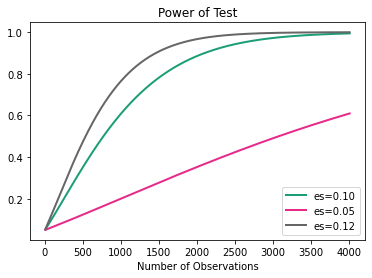

In [40]:
power_curves('alcohol',final)

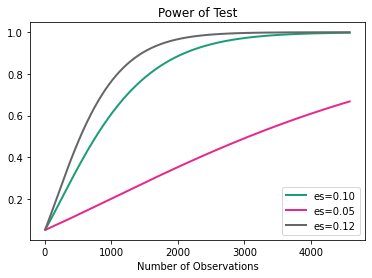

In [41]:
power_curves('tobacco',final)

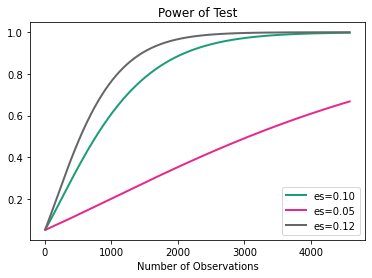

In [42]:
power_curves('depression',final)